
Training Logistic Regression...


C:\Users\bbuser\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
C:\Users\bbuser\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Logistic Regression Accuracy: 0.9197

Training SVM (RBF)...
SVM (RBF) Accuracy: 0.9643

Training Decision Tree...
Decision Tree Accuracy: 0.8738

Training Random Forest...
Random Forest Accuracy: 0.9682

Training XGBoost...
XGBoost Accuracy: 0.9766

Summary of all models:
                 Model  Accuracy  TrainTime_s
4              XGBoost  0.976571   300.994778
3        Random Forest  0.968214    65.086969
1            SVM (RBF)  0.964286  1091.470162
0  Logistic Regression  0.919714  8011.305180
2        Decision Tree  0.873786    98.259166


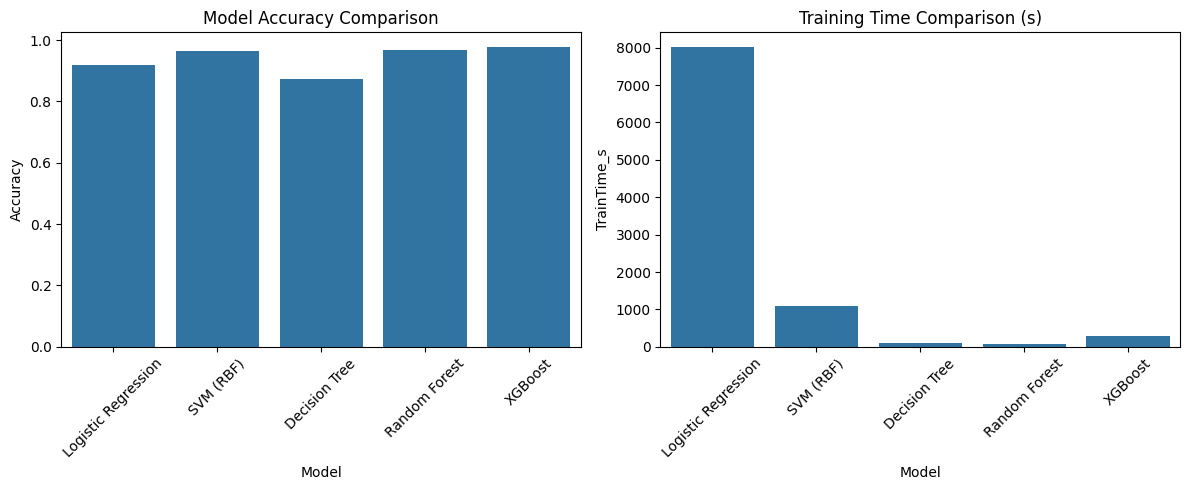

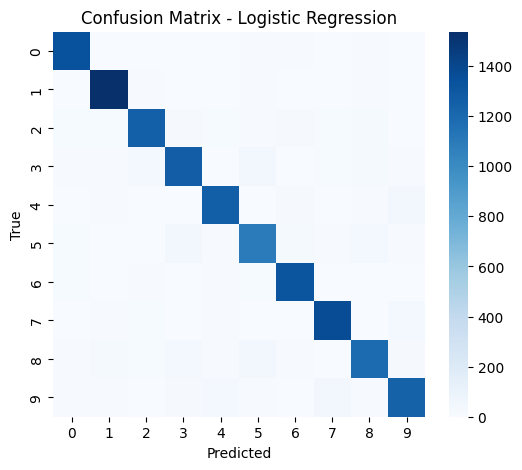

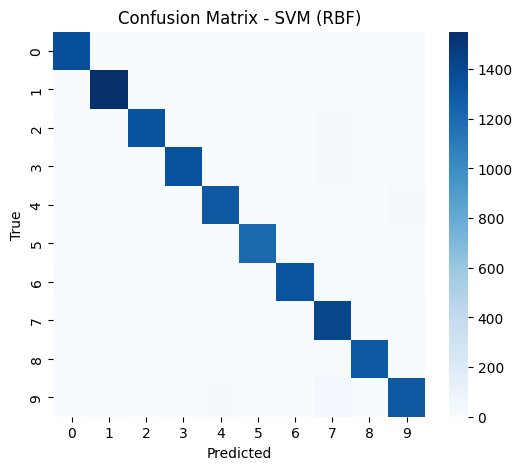

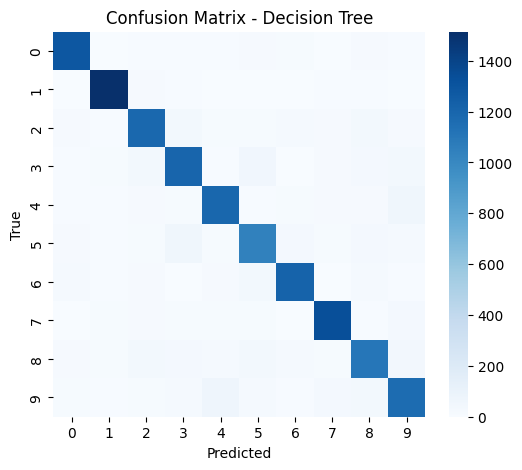

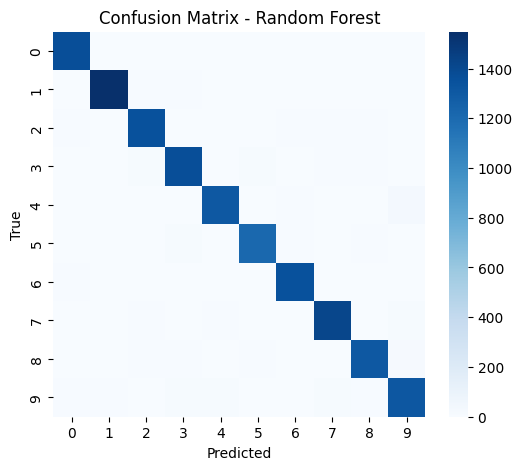

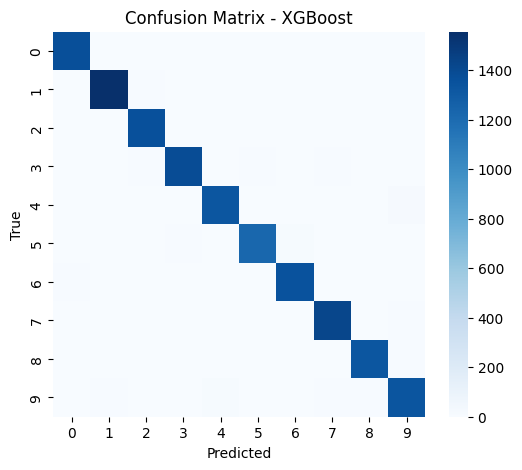

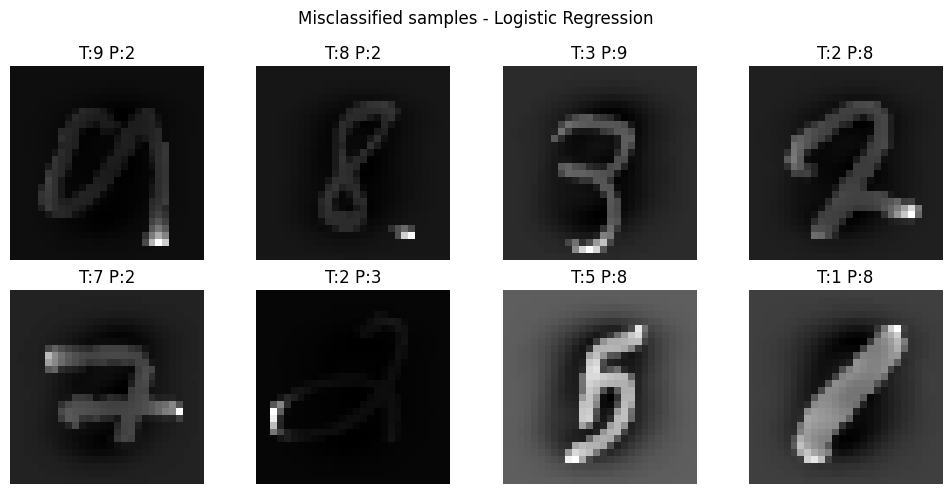

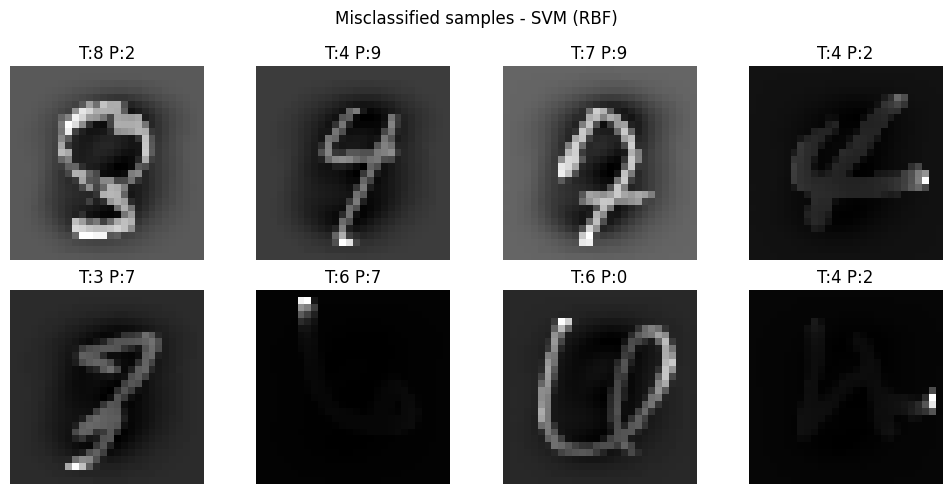

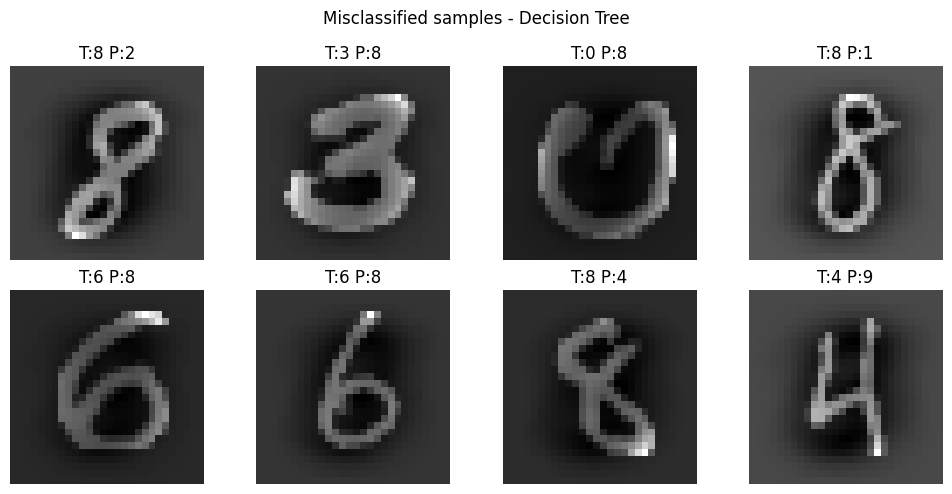

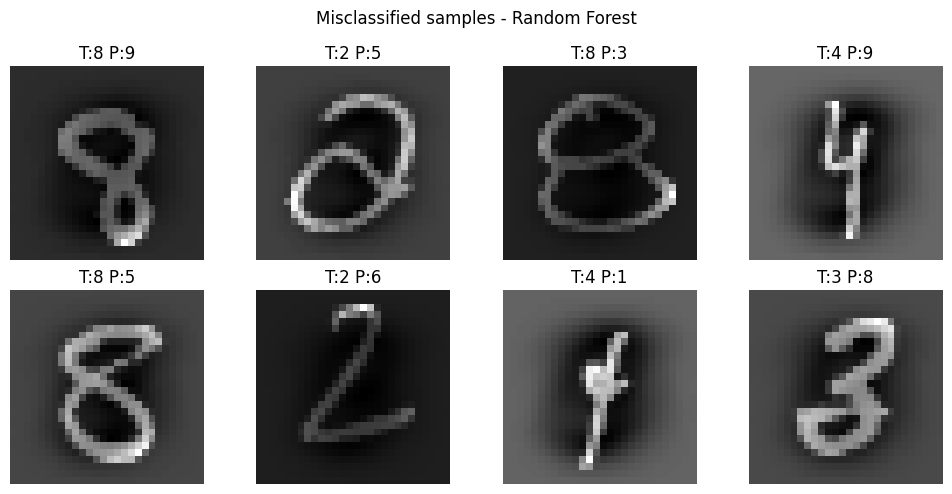

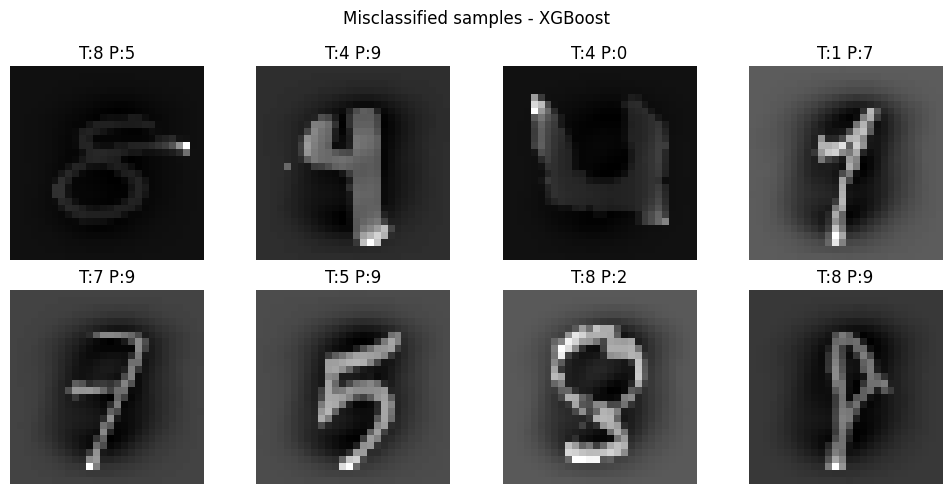

In [1]:
# -------------------------
# MNIST Classification Comparison
# -------------------------

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time

from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# XGBoost
import xgboost as xgb

# -------------------------
# 1. Load and Preprocess MNIST
# -------------------------
X, y = fetch_openml('mnist_784', version=1, as_frame=False, return_X_y=True)
y = y.astype(int)

# Normalize pixel values to [0,1]
X = X / 255.0

# Optional: standard scaling for SVM/other models
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Train/test split
RANDOM_STATE = 42
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
)

# -------------------------
# 2. Define Models
# -------------------------
models = {
    "Logistic Regression": LogisticRegression(
        max_iter=1000, solver='saga', multi_class='multinomial',
        n_jobs=-1, random_state=RANDOM_STATE
    ),
    "SVM (RBF)": SVC(kernel='rbf', probability=False, random_state=RANDOM_STATE),
    "Decision Tree": DecisionTreeClassifier(random_state=RANDOM_STATE),
    "Random Forest": RandomForestClassifier(n_estimators=200, n_jobs=-1, random_state=RANDOM_STATE),
    "XGBoost": xgb.XGBClassifier(
        use_label_encoder=False, eval_metric='mlogloss',
        random_state=RANDOM_STATE, n_jobs=-1, verbosity=0
    )
}

# -------------------------
# 3. Train, Evaluate, Collect Metrics
# -------------------------
results = []
trained_models = {}

for name, model in models.items():
    print(f"\nTraining {name}...")
    start_time = time.time()
    model.fit(X_train, y_train)
    train_time = time.time() - start_time
    trained_models[name] = model

    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, output_dict=True, zero_division=0)
    cm = confusion_matrix(y_test, y_pred)

    results.append({
        "model": name,
        "accuracy": acc,
        "train_time_s": train_time,
        "report": report,
        "confusion_matrix": cm
    })

    print(f"{name} Accuracy: {acc:.4f}")

# Summary table
summary_df = pd.DataFrame([{"Model": r["model"], "Accuracy": r["accuracy"], "TrainTime_s": r["train_time_s"]} for r in results])
print("\nSummary of all models:")
print(summary_df.sort_values("Accuracy", ascending=False))

# -------------------------
# 4. Visualization
# -------------------------
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
sns.barplot(data=summary_df, x="Model", y="Accuracy")
plt.xticks(rotation=45)
plt.title("Model Accuracy Comparison")

plt.subplot(1,2,2)
sns.barplot(data=summary_df, x="Model", y="TrainTime_s")
plt.xticks(rotation=45)
plt.title("Training Time Comparison (s)")
plt.tight_layout()
plt.show()

# Confusion matrices
for r in results:
    plt.figure(figsize=(6,5))
    sns.heatmap(r["confusion_matrix"], annot=False, fmt='d', cmap='Blues')
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(f"Confusion Matrix - {r['model']}")
    plt.show()

# -------------------------
# 5. Misclassified Examples
# -------------------------
def show_misclassified(model_name, model, X_test, y_test, n=8):
    y_pred = model.predict(X_test)
    mis_idx = np.where(y_pred != y_test)[0]
    if len(mis_idx) == 0:
        print(f"No misclassified samples for {model_name}")
        return
    sel = np.random.choice(mis_idx, size=min(n, len(mis_idx)), replace=False)
    ncols = 4
    nrows = int(np.ceil(len(sel)/ncols))
    plt.figure(figsize=(ncols*2.5, nrows*2.5))
    for i, idx in enumerate(sel):
        ax = plt.subplot(nrows, ncols, i+1)
        img = X_test[idx].reshape(28,28)
        plt.imshow(img, cmap='gray')
        plt.axis('off')
        ax.set_title(f"T:{y_test[idx]} P:{y_pred[idx]}")
    plt.suptitle(f"Misclassified samples - {model_name}")
    plt.tight_layout()
    plt.show()

for name, model in trained_models.items():
    show_misclassified(name, model, X_test, y_test, n=8)
